###  MicroGrad NP demo

Adapted from https://github.com/karpathy/micrograd/blob/master/demo.ipynb

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from microgradnp.engine import Value
from microgradnp.nn import Sequential, Linear, ReLU

In [3]:
np.random.seed(1337)
random.seed(1337)

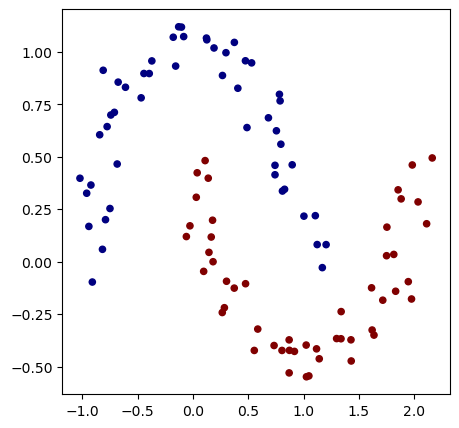

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model 
# Define dataset and model
input_features = 2
hidden_dim = 16
output_features = 1


model = Sequential(Linear(input_features, hidden_dim),
                   ReLU(),
                   Linear(hidden_dim, hidden_dim),
                   ReLU(),
                   Linear(hidden_dim, output_features))
print(model)
print("number of parameters", sum(v.data.size for v in model.parameters()))

number of parameters 337


In [6]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
        
    inputs = list(map(Value, Xb))

    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 - yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) / len(losses)
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p**2).sum() for p in model.parameters())

    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(_op=+, grad=[[0.]], data=[[1.58106339]]) [[0.48]]


In [7]:
# optimization
epochs = 100
for k in range(epochs):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/epochs
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%, lr {learning_rate}")


step 0 loss [[1.58106339]], accuracy [[48.]]%, lr 1.0
step 1 loss [[1.38485779]], accuracy [[68.]]%, lr 0.991
step 2 loss [[0.93471567]], accuracy [[74.]]%, lr 0.982
step 3 loss [[0.72704393]], accuracy [[78.]]%, lr 0.973
step 4 loss [[0.38479063]], accuracy [[84.]]%, lr 0.964
step 5 loss [[0.34811404]], accuracy [[85.]]%, lr 0.955
step 6 loss [[0.26926578]], accuracy [[88.]]%, lr 0.946
step 7 loss [[0.22378791]], accuracy [[91.]]%, lr 0.937
step 8 loss [[0.18317625]], accuracy [[92.]]%, lr 0.9279999999999999
step 9 loss [[0.18314398]], accuracy [[94.]]%, lr 0.919
step 10 loss [[0.23431048]], accuracy [[91.]]%, lr 0.91
step 11 loss [[0.25095461]], accuracy [[90.]]%, lr 0.901
step 12 loss [[0.18970387]], accuracy [[93.]]%, lr 0.892
step 13 loss [[0.13919248]], accuracy [[95.]]%, lr 0.883
step 14 loss [[0.14198196]], accuracy [[94.]]%, lr 0.874
step 15 loss [[0.15969667]], accuracy [[98.]]%, lr 0.865
step 16 loss [[0.44763846]], accuracy [[84.]]%, lr 0.856
step 17 loss [[0.1964421]], acc

(-1.548639298268643, 1.951360701731357)

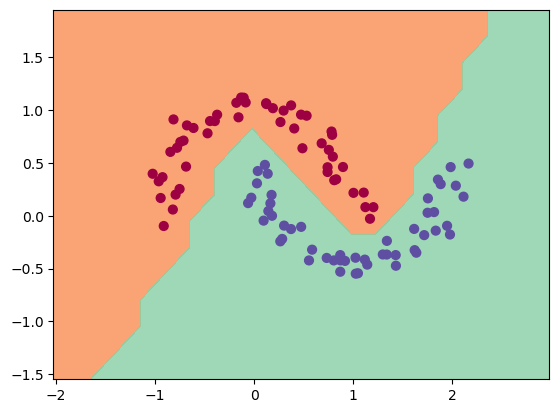

In [8]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = list(map(Value, Xmesh))
scores = np.array(list(map(model, inputs)))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
